---
# Predictive Modeling 
# Author: Adefemi Abimbola
---


In [2]:
#import necessary libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from tqdm import tqdm
import ast
import shap
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [3]:
#path to each cleaned data set unique to your system
review_path = '/Users/Defemi/Library/Mobile Documents/com~apple~CloudDocs/Data Sc II/Yelp JSON/reviews.csv'
business_path = '/Users/Defemi/Library/Mobile Documents/com~apple~CloudDocs/Data Sc II/Yelp JSON/business.csv'
user_path = '/Users/Defemi/Library/Mobile Documents/com~apple~CloudDocs/Data Sc II/Yelp JSON/user.csv'
checkin_path = '/Users/Defemi/Library/Mobile Documents/com~apple~CloudDocs/Data Sc II/Yelp JSON/checkin.csv'
tip_path = '/Users/Defemi/Library/Mobile Documents/com~apple~CloudDocs/Data Sc II/Yelp JSON/tip.csv'

In [4]:
# read the data
review = pd.read_csv(review_path)
business = pd.read_csv(business_path)
user = pd.read_csv(user_path)
checkin = pd.read_csv(checkin_path)
tip = pd.read_csv(tip_path)

In [6]:
# Aggregating the dataset into a master dataset
business.rename(columns={'name': 'business_name',
                         'address': 'business_address',
                         'city': 'business_city',
                         'stars': 'business_stars',
                         'review_count':'business_review_count',
                         'attributes':'business_attributes',
                         'categories':'business_categories',
                         'hours':'business_hours'}, inplace=True)
business.drop(columns=['is_open'], inplace=True)
review.rename(columns={'stars': 'review_stars',
                       'date': 'review_date',
                       'text': 'review'}, inplace=True)
review.drop(columns=['useful', 'funny','cool'], inplace=True)
user.rename(columns={'name': 'user_name',
                     'review_count': 'user_review_count',
                     'average_stars': 'user_average_stars',
                     'compliments_total': 'User_compliments_total'}, inplace=True)
user.drop(columns=['elite', 'fans'], inplace=True)
checkin.rename(columns={'date': 'checkin_dates'}, inplace=True)
master = review.merge(business, on='business_id', how='left')
master = master.merge(user, on='user_id', how='left')
master = master.merge(checkin, on='business_id', how='left')
master.dropna(inplace=True)

# master dataset created each row represents one review

In [7]:
master.columns

Index(['review_id', 'user_id', 'business_id', 'review_stars', 'review',
       'review_date', 'business_name', 'business_address', 'business_city',
       'state', 'postal_code', 'business_stars', 'business_review_count',
       'business_attributes', 'business_categories', 'business_hours',
       'user_name', 'user_review_count', 'user_average_stars',
       'User_compliments_total', 'checkin_dates'],
      dtype='object')

In [8]:
master.head()

,review_id,user_id,business_id,review_stars,review,review_date,business_name,business_address,business_city,state,...,business_stars,business_review_count,business_attributes,business_categories,business_hours,user_name,user_review_count,user_average_stars,User_compliments_total,checkin_dates
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,Turning Point of North Wales,1460 Bethlehem Pike,North Wales,PA,...,3.0,169,"{'NoiseLevel': ""u'average'"", 'HasTV': 'False',...","Restaurants, Breakfast & Brunch, Food, Juice B...","{'Monday': '7:30-15:0', 'Tuesday': '7:30-15:0'...",Melanie,33.0,4.06,2.0,"2017-04-15 15:45:08, 2017-04-17 15:27:01, 2017..."
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18,Body Cycle Spinning Studio,"1923 Chestnut St, 2nd Fl",Philadelphia,PA,...,5.0,144,"{'BusinessAcceptsCreditCards': 'True', 'GoodFo...","Active Life, Cycling Classes, Trainers, Gyms, ...","{'Monday': '6:30-20:30', 'Tuesday': '6:30-20:3...",Erin,10.0,4.30,0.0,"2011-02-26 13:45:56, 2011-03-08 00:05:30, 2011..."
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,Zaika,2481 Grant Ave,Philadelphia,PA,...,4.0,181,"{'Caters': 'True', 'Ambience': ""{'romantic': F...","Halal, Pakistani, Restaurants, Indian","{'Tuesday': '11:0-21:0', 'Wednesday': '11:0-21...",Kyle,9.0,4.78,1.0,"2011-04-21 22:41:07, 2011-04-26 20:59:22, 2011..."
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15,Melt,2549 Banks St,New Orleans,LA,...,4.0,32,"{'BusinessParking': ""{'garage': False, 'street...","Sandwiches, Beer, Wine & Spirits, Bars, Food, ...","{'Monday': '0:0-0:0', 'Friday': '11:0-17:0', '...",Sophia,126.0,2.97,4.0,"2016-12-30 20:46:48, 2016-12-30 20:52:41, 2017..."
5,JrIxlS1TzJ-iCu79ul40cQ,eUta8W_HdHMXPzLBBZhL1A,04UD14gamNjLY0IDYVhHJg,1.0,I am a long term frequent customer of this est...,2015-09-23 23:10:31,Dmitri's,795 S 3rd St,Philadelphia,PA,...,4.0,273,"{'BusinessParking': ""{'garage': False, 'street...","Mediterranean, Restaurants, Seafood, Greek","{'Wednesday': '17:30-21:0', 'Thursday': '17:30...",Q,4.0,2.00,1.0,"2010-03-27 22:04:48, 2010-07-13 00:09:00, 2010..."


---
- Predicting business star rating using simple features
    - Baseline Model - Linear regression
    - Final Model - Gradient Boosting
-  Built models to predict business star ratings using simple features; used Linear Regression as a baseline and Gradient Boosting as the primary model.
---

In [10]:
def extract_attribute(attr_str, key):
    try:
        attr_dict = ast.literal_eval(attr_str)
        return attr_dict.get(key, None)
    except:
        return None


In [11]:
def extract_parking_type(attr_str, parking_type):
    try:
        attr_dict = ast.literal_eval(attr_str)
        parking_str = attr_dict.get('BusinessParking')
        parking_dict = ast.literal_eval(parking_str) if parking_str else {}
        return parking_dict.get(parking_type, None)
    except:
        return None

In [12]:
def simplify_category(cat_string):
    if not isinstance(cat_string, str):
        return 'Other'
    
    cat_string = cat_string.lower()

    if 'restaurant' in cat_string or 'food' in cat_string:
        return 'Restaurant'
    elif 'shopping' in cat_string or 'store' in cat_string:
        return 'Retail'
    elif 'health' in cat_string or 'medical' in cat_string or 'nutritionist' in cat_string:
        return 'Health'
    elif 'beauty' in cat_string or 'spa' in cat_string or 'salon' in cat_string:
        return 'Beauty'
    elif 'bar' in cat_string or 'nightlife' in cat_string or 'club' in cat_string:
        return 'Nightlife'
    elif 'education' in cat_string or 'school' in cat_string:
        return 'Education'
    elif 'service' in cat_string or 'notary' in cat_string:
        return 'Professional Services'
    elif 'public service' in cat_string or 'government' in cat_string:
        return 'Government'
    elif 'automotive' in cat_string or 'car' in cat_string or 'mechanic' in cat_string or 'tire' in cat_string:
        return 'Automotive'
    elif 'gym' in cat_string or 'fitness' in cat_string or 'yoga' in cat_string or 'active life' in cat_string:
        return 'Fitness'
    elif 'pets' in cat_string or 'animal' in cat_string or 'veterinary' in cat_string:
        return 'Veterinary'
    elif 'hotel' in cat_string or 'lodging' in cat_string or 'travel' in cat_string:
        return 'Travel'
    elif 'church' in cat_string or 'temple' in cat_string or 'synagogue' in cat_string or 'place of worship' in cat_string:
        return 'Religious'
    elif 'movie' in cat_string or 'cinema' in cat_string or 'theater' in cat_string or 'art' in cat_string or 'museum' in cat_string or 'entertainment' in cat_string:
        return 'Entertainment'
    elif 'media' in cat_string or 'news' in cat_string or 'radio' in cat_string or 'television' in cat_string:
        return 'Media/Station'
    else:
        return 'Other'


In [14]:
# Preparing Data for Modeling 
master['review_length'] = master['review'].apply(lambda x: len(str(x).split()))

master['Wifi'] = master['business_attributes'].apply(lambda x: extract_attribute(x, 'WiFi'))
master['credit_cards'] = master['business_attributes'].apply(lambda x: extract_attribute(x, 'BusinessAcceptsCreditCards'))
master['bike_parking'] = master['business_attributes'].apply(lambda x: extract_attribute(x, 'BikeParking'))
master['parking_garage'] = master['business_attributes'].apply(lambda x: extract_parking_type(x, 'garage'))
master['parking_lot'] = master['business_attributes'].apply(lambda x: extract_parking_type(x, 'lot'))
master['parking_street'] = master['business_attributes'].apply(lambda x: extract_parking_type(x, 'street'))

# Encode WiFi
master['Wifi'].replace({"'free'": 2, "None": 1, "u'no'": 0, "u'free'": 2, "'no'": 0, "u'paid'": 1, "'paid'": 1,"'None'": 0}, inplace=True)
master['Wifi'] = master['Wifi'].fillna(0)

# simplifying the business categories
master['category_simple'] = master['business_categories'].apply(simplify_category)

/var/folders/t5/97cjl4mx5td1_8pcvlh1hxn80000gp/T/ipykernel_51879/3947988532.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  master['Wifi'].replace({"'free'": 2, "None": 1, "u'no'": 0, "u'free'": 2, "'no'": 0, "u'paid'": 1, "'paid'": 1,"'None'": 0}, inplace=True)
/var/folders/t5/97cjl4mx5td1_8pcvlh1hxn80000gp/T/ipykernel_51879/3947988532.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)

In [ ]:
# Dropping unnecessary columns and creating a seperate dataframe
business_df = master.groupby('business_id').agg({
    'review_stars': 'mean',  # Avg rating from users
    'user_review_count': 'mean',
    'user_average_stars': 'mean',
    'User_compliments_total': 'mean',
    'review_length': 'mean',
    'checkin_dates': lambda x: len(x.dropna()),  # num check-ins
    'Wifi': 'first',  # drop one later if duplicate
    'credit_cards': 'first',
    'bike_parking': 'first',
    'parking_garage': 'first',
    'parking_lot': 'first',
    'parking_street': 'first',
    'category_simple': 'first',
    'business_review_count': 'first',
    'business_stars': 'first',  # TARGET
})

business_df = business_df.reset_index()

# Converting categorical features to integers or binary columns
categorical_features = ['category_simple']
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded = encoder.fit_transform(business_df[categorical_features])

# Convert encoded to a DataFrame and concat with original
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_features))
business_df = pd.concat([business_df.reset_index(drop=True), encoded_df], axis=1)

# Drop original categorical column
business_df.drop(columns=categorical_features, inplace=True)



- Baseline Model - Linear Regression
___

In [ ]:
# Drop column business start review that is what we are predictiing 
drop_col = ['business_stars','business_id']

#Define X and y 
X = business_df.drop(columns=drop_col)
y = business_df['business_stars']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Convert categorical features to int
for col in categorical_features:
    business_df[col] = business_df[col].map({'True': 1, 'False': 0, None: 0, 'None': 0}).fillna(0)
    

In [147]:
# tarin the model
lr = LinearRegression()
lr.fit(X_train, y_train)

# predict the test set
y_pred = lr.predict(X_test)

# Evaluate the model
lr_mae = mean_absolute_error(y_test, y_pred)
lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
lr_r2 = r2_score(y_test, y_pred)

print(f"Linear Regression Baseline:")
print(f"Mean Absolute Error : {lr_mae:.4f}")
print(f"Root Mean-Square Error: {lr_rmse:.4f}")
print(f"R² Score: {lr_r2:.4f}")

# Cross-Validation (5-Fold)
lr_cv_mae = -cross_val_score(lr, X, y, cv=5, scoring='neg_mean_absolute_error')
lr_cv_r2 = cross_val_score(lr, X, y, cv=5, scoring='r2')
lr_y_pred_cv = cross_val_predict(lr, X, y, cv=5)
lr_cv_rmse = np.sqrt(mean_squared_error(y, lr_y_pred_cv))

print("\n📊 5-Fold Cross-Validation:")
print(f"Average MAE:  {lr_cv_mae.mean():.4f} (std: {lr_cv_mae.std():.4f})")
print(f"Average RMSE: {lr_cv_rmse:.4f}")
print(f"Average R²:   {lr_cv_r2.mean():.4f} (std: {lr_cv_r2.std():.4f})")



Linear Regression Baseline:
Mean Absolute Error : 0.1643
Root Mean-Square Error: 0.2341
R² Score: 0.9323

📊 5-Fold Cross-Validation:
Average MAE:  0.1620 (std: 0.0019)
Average RMSE: 0.2303
Average R²:   0.9340 (std: 0.0020)


Text(0.5, 1.0, 'Baseline Model - Linear Regression: Actual vs Predicted Ratings')

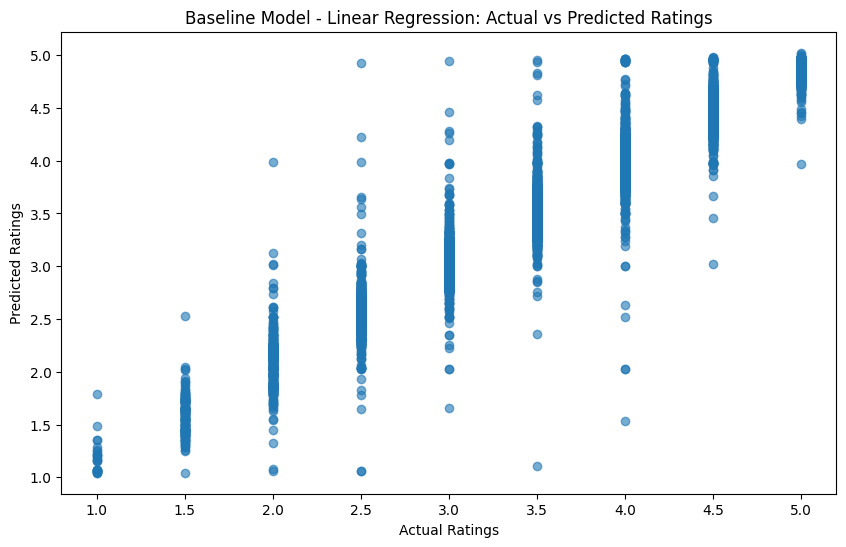

In [144]:
# plotting the predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
#plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Baseline Model - Linear Regression: Actual vs Predicted Ratings')

- Final Model - Gradient Boosting
---

In [148]:
# x-train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbr.fit(X_train, y_train)

# Predictions on test set
y_pred = gbr.predict(X_test)

# Evaluate on test set
mae_gbr = mean_absolute_error(y_test, y_pred)
rmse_gbr = np.sqrt(mean_squared_error(y_test, y_pred))
r2_gbr = r2_score(y_test, y_pred)

print("🔍 Gradient Boosting on Test Set:")
print(f"Mean Absolute Error:  {mae_gbr:.4f}")
print(f"Root Mean-Square Error: {rmse_gbr:.4f}")
print(f"R²:   {r2_gbr:.4f}")

# Cross-Validation (5-Fold)
cv_mae_gbr = -cross_val_score(gbr, X, y, cv=5, scoring='neg_mean_absolute_error')
cv_r2_gbr = cross_val_score(gbr, X, y, cv=5, scoring='r2')
y_pred_cv_gbr = cross_val_predict(gbr, X, y, cv=5)
cv_rmse_gbr = np.sqrt(mean_squared_error(y, y_pred_cv))

print("\n📊 5-Fold Cross-Validation:")
print(f"Average MAE:  {cv_mae_gbr.mean():.4f} (std: {cv_mae_gbr.std():.4f})")
print(f"Average RMSE: {cv_rmse_gbr:.4f}")
print(f"Average R²:   {cv_r2_gbr.mean():.4f} (std: {cv_r2_gbr.std():.4f})")


🔍 Gradient Boosting on Test Set:
Mean Absolute Error:  0.1101
Root Mean-Square Error: 0.2115
R²:   0.9447

📊 5-Fold Cross-Validation:
Average MAE:  0.1068 (std: 0.0021)
Average RMSE: 0.2303
Average R²:   0.9472 (std: 0.0021)


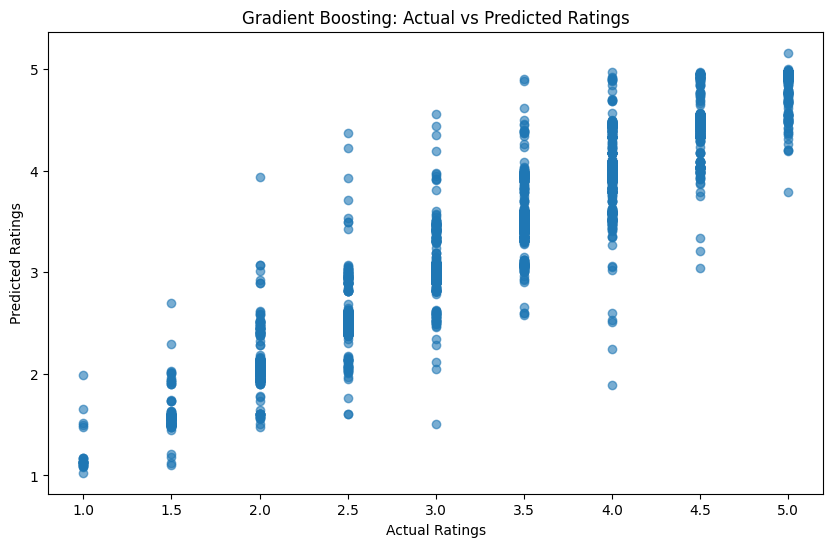

In [142]:
# plotting the predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Gradient Boosting: Actual vs Predicted Ratings')
plt.show()


In [154]:
# comparing the baseline model to the final model

print("\n🔍 Test Set Evaluation:")
print(f"{'Metric':<8} {'Linear Reg':>12} {'Gradient Boost':>18}")
print(f"{'MAE':<10} {lr_mae:.4f} {mae_gbr:>18.4f}")
print(f"{'RMSE':<10} {lr_rmse:.4f} {rmse_gbr:>18.4f}")
print(f"{'R²':<10} {lr_r2:.4f} {r2_gbr:>18.4f}")

print("\n📊 5-Fold Cross-Validation:")
print(f"{'Metric':<8} {'Linear Reg':>12} {'Gradient Boost':>18}")
print(f"{'MAE':<10} {lr_cv_mae.mean():.4f} {cv_mae_gbr.mean():>18.4f}")
print(f"{'RMSE':<10} {lr_cv_rmse:.4f} {cv_rmse_gbr:>18.4f}")
print(f"{'R²':<10} {lr_cv_r2.mean():.4f} {cv_r2_gbr.mean():>18.4f}")



🔍 Test Set Evaluation:
Metric     Linear Reg     Gradient Boost
MAE        0.1643             0.1101
RMSE       0.2341             0.2115
R²         0.9323             0.9447

📊 5-Fold Cross-Validation:
Metric     Linear Reg     Gradient Boost
MAE        0.1620             0.1068
RMSE       0.2303             0.2303
R²         0.9340             0.9472


---
- Classifying business success level (Struggling, Stable, Successful) based on operational and user-related features
    - Baseline Model – Most Frequent Class
    - Final Model – Gradient Boosting Classifier
- Built models to classify business success levels (Struggling, Stable, Successful) based on operational and user-related features; used Most Frequent Class as a baseline and Gradient Boosting Classifier as the primary model.
---

In [166]:
business_df

,business_id,review_stars,user_review_count,user_average_stars,User_compliments_total,review_length,checkin_dates,Wifi,credit_cards,bike_parking,...,category_simple_Health,category_simple_Media/Station,category_simple_Nightlife,category_simple_Professional Services,category_simple_Religious,category_simple_Restaurant,category_simple_Retail,category_simple_Travel,category_simple_Veterinary,business_status
0,---kPU91CF4Lq2-WlRu9Lw,4.500000,43.958333,3.874167,4.000000,54.500000,24,0.0,1,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Successful
1,--FWWsIwxRwuw9vIMImcQg,3.250000,122.875000,4.005000,62.000000,95.375000,8,0.0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Stable
2,--SJXpAa0E-GCp2smaHf0A,2.400000,127.300000,3.288000,76.400000,142.100000,10,0.0,1,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Struggling
3,--ZVrH2X2QXBFdCilbirsw,4.722222,167.277778,4.052222,351.305556,69.333333,36,2.0,1,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Successful
4,--_lZuj_WCGnDG6n0emlRg,2.230769,425.153846,3.320769,211.538462,84.846154,13,0.0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Struggling
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31217,zzbZtgPYZS8sTIWQH6DwEw,2.863014,241.808219,3.436301,443.397260,110.328767,73,0.0,1,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Stable
31218,zziDpuuJw-Km1J4BaGpBKA,3.333333,118.666667,3.758333,72.000000,116.833333,6,0.0,1,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Stable
31219,zzjFdJwXuxBOGe9JeY_EMw,4.104167,41.104167,3.775625,7.770833,69.708333,48,0.0,1,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Successful
31220,zznJox6-nmXlGYNWgTDwQQ,1.633333,57.666667,2.973333,5.866667,75.000000,30,2.0,1,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Struggling


In [156]:
business_df.columns

Index(['business_id', 'review_stars', 'user_review_count',
       'user_average_stars', 'User_compliments_total', 'review_length',
       'checkin_dates', 'Wifi', 'credit_cards', 'bike_parking',
       'parking_garage', 'parking_lot', 'parking_street',
       'business_review_count', 'business_stars', 'category_simple_Automotive',
       'category_simple_Beauty', 'category_simple_Education',
       'category_simple_Entertainment', 'category_simple_Fitness',
       'category_simple_Health', 'category_simple_Media/Station',
       'category_simple_Nightlife', 'category_simple_Professional Services',
       'category_simple_Religious', 'category_simple_Restaurant',
       'category_simple_Retail', 'category_simple_Travel',
       'category_simple_Veterinary'],
      dtype='object')

In [167]:
def classify_business(stars):
    if stars < 3.0:
        return 'Struggling'
    elif stars < 4.0:
        return 'Stable'
    else:
        return 'Successful'

business_df['business_status'] = business_df['business_stars'].apply(classify_business)

business_df['business_status'].value_counts()


business_status
Successful    15952
Stable         9821
Struggling     5449
Name: count, dtype: int64

In [168]:
X_class = business_df.drop(columns=['business_stars', 'business_status','business_id'])  # drop target + optional
y_class = business_df['business_status']

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_class, y_class, test_size=0.2, random_state=42, stratify=y_class)


- Baseline Model – Most Frequent Class
---

In [174]:
# Create and train the baseline model
baseline_clf = DummyClassifier(strategy='most_frequent')
baseline_clf.fit(X_train_clf, y_train_clf)

# Predict and evaluate
y_pred_baseline = baseline_clf.predict(X_test_clf)

cv_scores_baseline = cross_val_score(baseline_clf, X_class, y_class,cv=5, scoring='f1_weighted')

print("📉 Baseline Model (Most Frequent Class):\n")
print(classification_report(y_test_clf, y_pred_baseline))
print("Confusion Matrix:")
print(confusion_matrix(y_test_clf, y_pred_baseline))

print("📉 Baseline Model - 5-Fold CV F1 (weighted):")
print("Scores:", cv_scores_baseline)
print("Average F1:", np.mean(cv_scores_baseline))

📉 Baseline Model (Most Frequent Class):

              precision    recall  f1-score   support

      Stable       0.00      0.00      0.00      1964
  Struggling       0.00      0.00      0.00      1090
  Successful       0.51      1.00      0.68      3191

    accuracy                           0.51      6245
   macro avg       0.17      0.33      0.23      6245
weighted avg       0.26      0.51      0.35      6245

Confusion Matrix:
[[   0    0 1964]
 [   0    0 1090]
 [   0    0 3191]]
📉 Baseline Model - 5-Fold CV F1 (weighted):
Scores: [0.34559164 0.34559164 0.34550361 0.34550361 0.34550361]
Average F1: 0.3455388251720545


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

- Final Model – Gradient Boosting Classifier
---

In [175]:
# train the model
gbc = GradientBoostingClassifier(n_estimators=100,learning_rate=0.1,max_depth=3,random_state=42)
gbc.fit(X_train_clf, y_train_clf)

y_pred_gbc = gbc.predict(X_test_clf)

print("🌟 Gradient Boosting Classifier:\n")
print(classification_report(y_test_clf, y_pred_gbc))
print("Confusion Matrix:")
print(confusion_matrix(y_test_clf, y_pred_gbc))

cv_scores_gbc = cross_val_score(gbc, X_class, y_class,cv=5, scoring='f1_weighted')

print("\n🌟 Gradient Boosting Classifier - 5-Fold CV F1 (weighted):")
print("Scores:", cv_scores_gbc)
print("Average F1:", np.mean(cv_scores_gbc))

🌟 Gradient Boosting Classifier:

              precision    recall  f1-score   support

      Stable       0.94      0.92      0.93      1964
  Struggling       0.95      0.93      0.94      1090
  Successful       0.96      0.98      0.97      3191

    accuracy                           0.95      6245
   macro avg       0.95      0.94      0.95      6245
weighted avg       0.95      0.95      0.95      6245

Confusion Matrix:
[[1798   51  115]
 [  66 1015    9]
 [  57    4 3130]]

🌟 Gradient Boosting Classifier - 5-Fold CV F1 (weighted):
Scores: [0.94760131 0.94114811 0.94623682 0.95134598 0.9485107 ]
Average F1: 0.9469685835326063


In [176]:
print("\n📊 5-Fold Cross-Validation Comparison (F1-weighted):")
print(f"{'Model':<25} {'F1 Scores':<40} {'Average F1':>12}")
print("-" * 80)
print(f"{'Baseline (Most Frequent)':<25} {str(cv_scores_baseline.tolist()):<40} {np.mean(cv_scores_baseline):>12.4f}")
print(f"{'Gradient Boosting':<25} {str(cv_scores_gbc.tolist()):<40} {np.mean(cv_scores_gbc):>12.4f}")



📊 5-Fold Cross-Validation Comparison (F1-weighted):
Model                     F1 Scores                                  Average F1
--------------------------------------------------------------------------------
Baseline (Most Frequent)  [0.3455916407564373, 0.3455916407564373, 0.34550361478246594, 0.34550361478246594, 0.34550361478246594]       0.3455
Gradient Boosting         [0.9476013069519659, 0.9411481077831295, 0.9462368201784477, 0.9513459842691943, 0.9485106984802941]       0.9470


---
- Forecasting business activity over time (reviews and check-ins) using historical patterns
    - Baseline Model – Naive Forecast
    - Final Model – Time Series Regression (e.g., Gradient Boosting or ARIMA)
- Built models to forecast review volume and check-in frequency for businesses over a 6-month horizon using historical activity data; implemented a Naive Forecast as a baseline and used Gradient Boosting Regressor for advanced time series predictions.
---

In [177]:
master.columns

Index(['review_id', 'user_id', 'business_id', 'review_stars', 'review',
       'review_date', 'business_name', 'business_address', 'business_city',
       'state', 'postal_code', 'business_stars', 'business_review_count',
       'business_attributes', 'business_categories', 'business_hours',
       'user_name', 'user_review_count', 'user_average_stars',
       'User_compliments_total', 'checkin_dates', 'review_length', 'WiFi',
       'credit_cards', 'bike_parking', 'parking_garage', 'parking_lot',
       'parking_street', 'Wifi', 'category_simple'],
      dtype='object')

In [178]:
# format the data for the time series model

# Convert the review_date to datetime
master['review_date'] = pd.to_datetime(master['review_date'])

master['year_month'] = master['review_date'].dt.to_period('M').astype(str)

# Group by business_id and year_month, and calculate the average rating
reviews_monthly = (master.groupby(['business_id', 'year_month']).size().reset_index(name='review_count'))

In [1]:
# Drop rows with missing check-in data first
checkin_expanded = master[['business_id', 'checkin_dates']].dropna()


NameError: name 'master' is not defined

In [ ]:


# Split and explode
checkin_expanded['checkin_dates'] = checkin_expanded['checkin_dates'].str.split(', ')
checkin_expanded = checkin_expanded.explode('checkin_dates')

# Convert to datetime
checkin_expanded['checkin_datetime'] = pd.to_datetime(checkin_expanded['checkin_dates'], errors='coerce')

# Drop any rows where conversion failed
checkin_expanded = checkin_expanded.dropna(subset=['checkin_datetime'])


In [182]:
master['checkin_dates'].head(10)

0     2017-04-15 15:45:08, 2017-04-17 15:27:01, 2017...
1     2011-02-26 13:45:56, 2011-03-08 00:05:30, 2011...
3     2011-04-21 22:41:07, 2011-04-26 20:59:22, 2011...
4     2016-12-30 20:46:48, 2016-12-30 20:52:41, 2017...
5     2010-03-27 22:04:48, 2010-07-13 00:09:00, 2010...
6     2014-09-27 17:08:33, 2014-11-22 01:49:37, 2014...
7     2015-03-01 00:29:31, 2015-03-18 01:35:40, 2015...
9     2010-03-25 03:55:31, 2010-04-17 22:52:08, 2010...
10    2013-06-05 20:42:50, 2013-06-05 20:42:59, 2014...
11    2014-10-02 12:48:43, 2014-10-03 17:05:35, 2014...
Name: checkin_dates, dtype: object

In [ ]:
# Convert 'date' column in review data
review['date'] = pd.to_datetime(review['date'])

# Group by business and month
review_ts = review.groupby(['business_id', review['date'].dt.to_period('M')]).size().reset_index(name='review_count')

# Convert period back to datetime
review_ts['date'] = review_ts['date'].dt.to_timestamp()

review_ts.head()

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(biz_df['date'], biz_df['review_count'], linestyle='-')

In [ ]:
# Pick one business with enough reviews
top_business = review_ts['business_id'].value_counts().index[1]

biz_df = review_ts[review_ts['business_id'] == top_business].sort_values('date')


# Format data for Prophet
df_prophet = biz_df[['date', 'review_count']].rename(columns={'date': 'ds','review_count': 'y'})

# Fit the model
model = Prophet()
model.fit(df_prophet)

# Forecast 6 months into the future
future = model.make_future_dataframe(periods=6, freq='M')
forecast = model.predict(future)

# Only grab forecast points beyond the last actual date
last_date = df_prophet['ds'].max()
future_forecast = forecast[forecast['ds'] > last_date]

'''# Plot the forecast
# Combine with actuals for plotting
plot_df = pd.concat([
    df_prophet.rename(columns={'y': 'value'}).assign(type='actual'),
    future_forecast[['ds', 'yhat']].rename(columns={'yhat': 'value'}).assign(type='forecast')
])

plt.figure(figsize=(10, 5))

# Plot actual
actual = plot_df[plot_df['type'] == 'actual']
plt.plot(actual['ds'], actual['value'], label='Actual', color='blue', linewidth=2)

# Plot forecast
forecast_part = plot_df[plot_df['type'] == 'forecast']
plt.plot(forecast_part['ds'], forecast_part['value'], label='Forecast', color='red', linestyle='-', linewidth=2)

plt.xlabel('Date')
plt.ylabel('Review Count')
plt.title('Review Volume Forecast (6 Months)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()'''


# Get last point of actuals
last_actual = df_prophet.iloc[-1][['ds', 'y']]
bridge_point = pd.DataFrame({
    'ds': [last_actual['ds']],
    'value': [last_actual['y']],
    'type': ['forecast']  # Label it forecast so it draws as part of red line
})

# Combine everything
forecast_part = future_forecast[['ds', 'yhat']].rename(columns={'yhat': 'value'}).assign(type='forecast')
forecast_part = pd.concat([bridge_point, forecast_part], ignore_index=True)

# Recombine with actuals
plot_df = pd.concat([
    df_prophet.rename(columns={'y': 'value'}).assign(type='actual'),
    forecast_part
])

# Plot
plt.figure(figsize=(10, 5))

# Actual
actual = plot_df[plot_df['type'] == 'actual']
plt.plot(actual['ds'], actual['value'], label='Actual', color='blue', linewidth=2)

# Forecast (with bridge point)
forecast_line = plot_df[plot_df['type'] == 'forecast']
plt.plot(forecast_line['ds'], forecast_line['value'], label='Forecast', color='red', linestyle='-', linewidth=2)

plt.xlabel('Date')
plt.ylabel('Review Count')
plt.title('Review Volume Forecast (6 Months)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




In [ ]:
checkin

In [ ]:
# Explode date field into individual rows
checkin = checkin.explode('date')

# If date field is still one big string of timestamps
checkin= checkin.assign(date=checkin['date'].str.split(', ')).explode('date')
checkin['date'] = pd.to_datetime(checkin['date'])

checkin

In [ ]:
# Group by business and month
checkin_ts = checkin.groupby(['business_id',checkin['date'].dt.to_period('M')]).size().reset_index(name='checkin_count')

# Convert period to timestamp
checkin_ts['date'] = checkin_ts['date'].dt.to_timestamp()

# Pick one business with lots of check-ins
top_checkin_biz = checkin_ts['business_id'].value_counts().index[0]

biz_checkin_df = checkin_ts[checkin_ts['business_id'] == top_checkin_biz].sort_values('date')


In [ ]:
df_checkin_prophet = biz_checkin_df[['date', 'checkin_count']].rename(columns={
    'date': 'ds',
    'checkin_count': 'y'
})

model_checkin = Prophet()
model_checkin.fit(df_checkin_prophet)

future_checkins = model_checkin.make_future_dataframe(periods=24, freq='M')
forecast_checkin = model_checkin.predict(future_checkins)

In [ ]:
# Get last actual point
last_actual_ck = df_checkin_prophet.iloc[-1][['ds', 'y']]
bridge_ck = pd.DataFrame({
    'ds': [last_actual_ck['ds']],
    'value': [last_actual_ck['y']],
    'type': ['forecast']
})

# Format forecast values
forecast_part_ck = forecast_checkin[forecast_checkin['ds'] > last_actual_ck['ds']]
forecast_part_ck = forecast_part_ck[['ds', 'yhat']].rename(columns={'yhat': 'value'}).assign(type='forecast')
forecast_part_ck = pd.concat([bridge_ck, forecast_part_ck], ignore_index=True)

# Combine
plot_df_ck = pd.concat([
    df_checkin_prophet.rename(columns={'y': 'value'}).assign(type='actual'),
    forecast_part_ck
])

# Plot

plt.figure(figsize=(10, 5))

actual_ck = plot_df_ck[plot_df_ck['type'] == 'actual']
forecast_ck = plot_df_ck[plot_df_ck['type'] == 'forecast']

plt.plot(actual_ck['ds'], actual_ck['value'], label='Actual', color='blue', linewidth=2)
plt.plot(forecast_ck['ds'], forecast_ck['value'], label='Forecast', color='red', linestyle='-', linewidth=2)

plt.xlabel('Date')
plt.ylabel('Check-in Count')
plt.title('Check-in Frequency Forecast (6 Months)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
business_forecast = {}

for biz_id in tqdm(review_ts['business_id'].unique()):
    biz_data = review_ts[review_ts['business_id'] == biz_id].sort_values('date')
    if len(biz_data) < 12:
        continue  # skip short histories
    
    df_biz = biz_data[['date', 'review_count']].rename(columns={'date': 'ds', 'review_count': 'y'})
    
    try:
        model = Prophet()
        model.fit(df_biz)

        future = model.make_future_dataframe(periods=6, freq='M')
        forecast = model.predict(future)

        forecast_next6 = forecast[forecast['ds'] > df_biz['ds'].max()]
        total_predicted_reviews = forecast_next6['yhat'].sum()
        business_forecast[biz_id] = total_predicted_reviews
    except:
        business_forecast[biz_id] = None


In [ ]:
baseline_df['future_6mo_reviews'] = baseline_df['business_id'].map(business_forecast)

In [ ]:
checkin_ts

In [ ]:
checkin_forecast = {}

for biz_id in tqdm(checkin_ts['business_id'].unique()):
    biz_data = checkin_ts[checkin_ts['business_id'] == biz_id].sort_values('date')
    if len(biz_data) < 12:
        continue
    
    df_biz = biz_data[['date', 'checkin_count']].rename(columns={'date': 'ds', 'checkin_count': 'y'})
    
    try:
        model = Prophet()
        model.fit(df_biz)

        future = model.make_future_dataframe(periods=6, freq='M')
        forecast = model.predict(future)

        forecast_next6 = forecast[forecast['ds'] > df_biz['ds'].max()]
        total_predicted_checkins = forecast_next6['yhat'].sum()
        checkin_forecast[biz_id] = total_predicted_checkins
    except:
        checkin_forecast[biz_id] = None


In [ ]:
baseline_df['future_6mo_checkins'] = baseline_df['business_id'].map(checkin_forecast)